### Defining the library 

In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout,
Activation, Flatten,
MaxPooling2D, SimpleRNN)
from sklearn.model_selection import train_test_split

### Steps Definign the Activation Function - 'Relu' ,Using  Dropout to Prevent Overfiting

In [2]:
from keras.layers import Input

n_steps = 13
n_features = 1
model = Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(SimpleRNN(512, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])

### split_sequence function to define the lookback period

In [3]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
ticker = ['AAPL', 'MSFT']
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1 ,1)
stock_prices = yf.download(ticker,start=start, end = end, interval='1d')

[*********************100%%**********************]  2 of 2 completed


In [5]:
print(stock_prices.columns)

MultiIndex([('Adj Close', 'AAPL'),
            ('Adj Close', 'MSFT'),
            (    'Close', 'AAPL'),
            (    'Close', 'MSFT'),
            (     'High', 'AAPL'),
            (     'High', 'MSFT'),
            (      'Low', 'AAPL'),
            (      'Low', 'MSFT'),
            (     'Open', 'AAPL'),
            (     'Open', 'MSFT'),
            (   'Volume', 'AAPL'),
            (   'Volume', 'MSFT')],
           names=['Price', 'Ticker'])


In [6]:
diff_stock_prices = stock_prices.diff().dropna()

split = int(len(diff_stock_prices[('Adj Close', 'AAPL')].values) * 0.95)
diff_train_aapl = diff_stock_prices[('Adj Close', 'AAPL')].iloc[:split]
diff_test_aapl = diff_stock_prices[('Adj Close', 'AAPL')].iloc[split:]
diff_train_msft = diff_stock_prices[('Adj Close', 'MSFT')].iloc[:split]
diff_test_msft = diff_stock_prices[('Adj Close', 'MSFT')].iloc[split:]

In [7]:
X_aapl, y_aapl = split_sequence(diff_train_aapl, n_steps)
X_aapl = X_aapl.reshape((X_aapl.shape[0], X_aapl.shape[1], n_features))

In [8]:
history = model.fit(X_aapl, y_aapl,epochs=400, batch_size=150, verbose=0,validation_split = 0.10)

In [9]:
start = X_aapl[X_aapl.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [10]:
x_input = diff_train_aapl[-n_steps:].values
tempList_aapl = []
for i in range(len(diff_test_aapl)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input[0], yhat)[1:]
    tempList_aapl.append(yhat)

In [11]:
X_msft, y_msft = split_sequence(diff_train_msft, n_steps)
X_msft = X_msft.reshape((X_msft.shape[0], X_msft.shape[1],
n_features))

In [12]:
history = model.fit(X_msft, y_msft,
epochs=400, batch_size=150, verbose=0,
validation_split = 0.10)

In [13]:
start = X_msft[X_msft.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [14]:
tempList_msft = []
for i in range(len(diff_test_msft)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_msft.append(yhat)

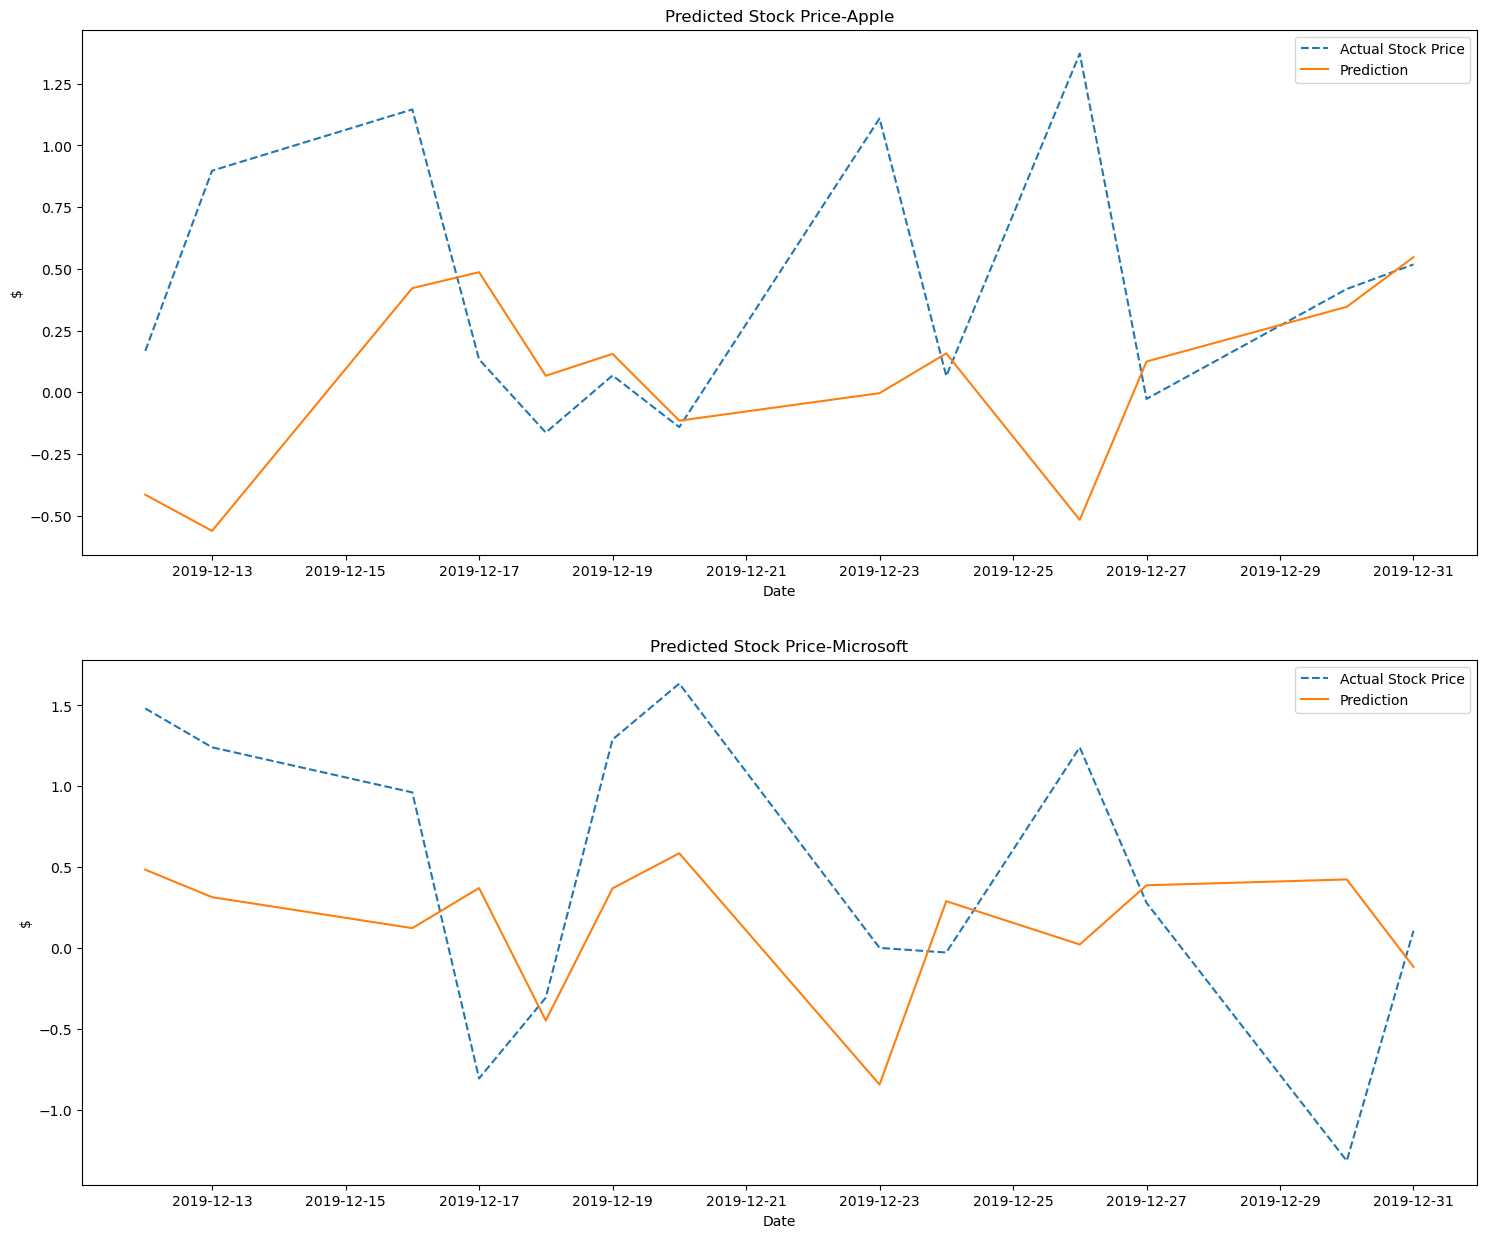

In [16]:
fig, ax = plt.subplots(2,1, figsize=(18,15))
ax[0].plot(diff_test_aapl, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_aapl.index, np.array(tempList_aapl).flatten(), linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock Price-Apple')
ax[0].legend(loc='best')

ax[1].plot(diff_test_msft, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_msft.index, np.array(tempList_msft).flatten(), linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-Microsoft')
ax[1].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='$')

plt.show()

### There is always a scope of improvement in the Predcition so is here The problem that simple RNN Faces is known as Vanashing Gradient OR Exploding Gradient   - "The vanishing gradientproblem arises if the gradient tends to get smaller as we conduct the backpropagation. It implies that neurons are learning so slowly that optimization grinds to a halt."

### LSTM tries to attack the weakness of RNN regarding long-term dependencies. LSTM has a quite useful tool to get rid of the unnecessary information so that it works more efficiently. LSTM works with gates, enabling it to forget irrelevant data. These gates are: 
### • Forget gates
### • Input gates
### • Output gates

In [15]:
from tensorflow.keras.layers import LSTM

In [16]:
n_steps = 13
n_features = 1

In [21]:
model = Sequential()
model.add(LSTM(512, activation='relu',
    input_shape=(n_steps, n_features),
    return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [22]:
model.compile(optimizer='rmsprop', loss='mean_squared_error',
                metrics=['mse'])

In [23]:
history = model.fit(X_aapl, y_aapl,
                    epochs=400, batch_size=150, verbose=0,
                    validation_split = 0.10)

In [24]:
start = X_aapl[X_aapl.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [25]:
tempList_aapl = []
for i in range(len(diff_test_aapl)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_aapl.append(yhat)

In [26]:
history = model.fit(X_msft, y_msft,
epochs=400, batch_size=150, verbose=0,
validation_split = 0.10)

In [28]:
start = X_msft[X_msft.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [29]:
tempList_msft = []
for i in range(len(diff_test_msft)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_msft.append(yhat)

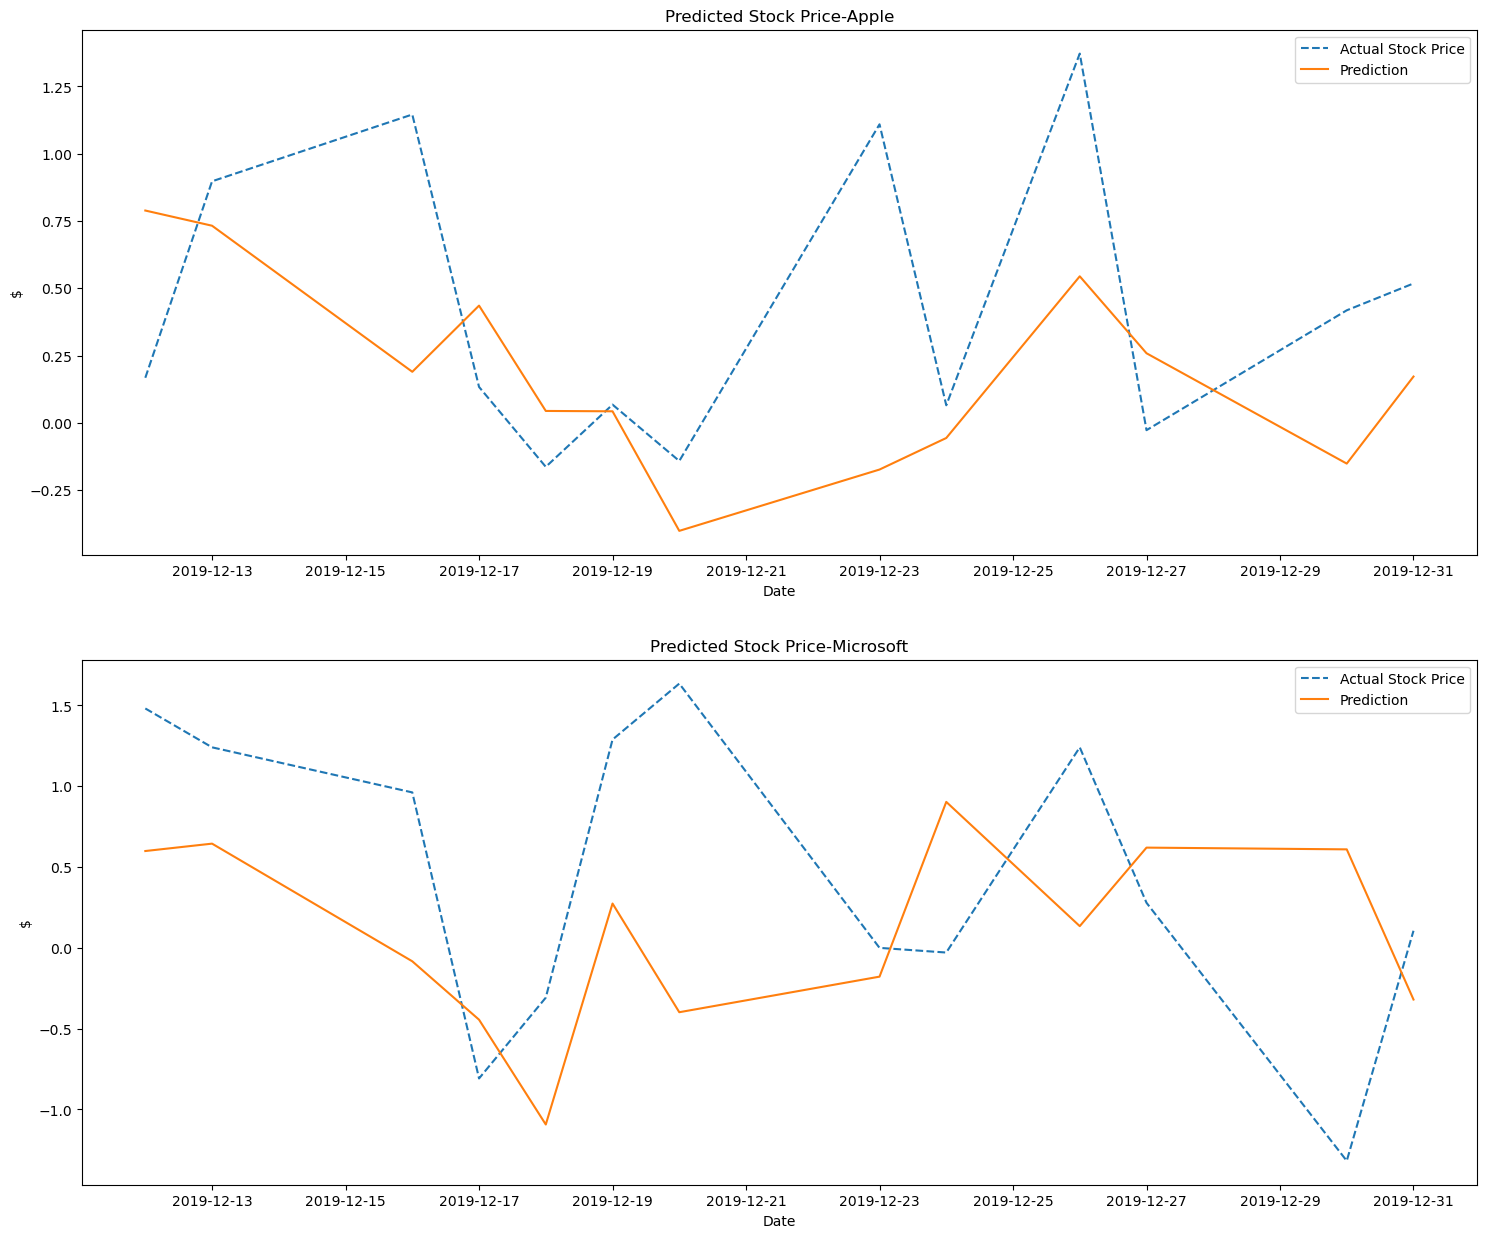

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(18, 15))
ax[0].plot(diff_test_aapl, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_aapl.index, np.array(tempList_aapl).flatten(),
linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock Price-Apple')
ax[0].legend(loc='best')
ax[1].plot(diff_test_msft, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_msft.index, np.array(tempList_msft).flatten(),
linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-Microsoft')
ax[1].legend(loc='best')
for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='$')
plt.show()

### The models used are RNN and LSTM, which have the ability to process longer time periods. These models do not suggest remarkable improvement but still can be employed to model time series data